In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
from sklearn.utils import resample

# Load and prepare the dataset
def load_and_prepare_data():
    train_data = pd.read_csv('train_data(new).csv')
    val_data = pd.read_csv('val_data(new).csv')
    test_data = pd.read_csv('test_data(new).csv')

    train_data['Entry_Date'] = pd.to_datetime(train_data['Entry_Date'])
    val_data['Entry_Date'] = pd.to_datetime(val_data['Entry_Date'])
    test_data['Entry_Date'] = pd.to_datetime(test_data['Entry_Date'])

    train_data = train_data.sort_values(by='Entry_Date')
    val_data = val_data.sort_values(by='Entry_Date')
    test_data = test_data.sort_values(by='Entry_Date')

    train_data.dropna(inplace=True)
    val_data.dropna(inplace=True)
    test_data.dropna(inplace=True)
    
    return train_data, val_data, test_data

# Train the model with provided parameters
def train_model(train_data, val_data, params, features, target):
    rf_clf = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=42
    )
    rf_clf.fit(train_data[features], train_data[target])
    
    # Apply Platt scaling
    calibrated_rf_clf = CalibratedClassifierCV(estimator=rf_clf, method='sigmoid')
    calibrated_rf_clf.fit(train_data[features], train_data[target])
    
    # Evaluate on validation set
    y_val_pred = calibrated_rf_clf.predict(val_data[features])
    y_val_pred_proba = calibrated_rf_clf.predict_proba(val_data[features])[:, 1]
    print("----- Validation Set Evaluation -----")
    print(classification_report(val_data[target], y_val_pred))
    roc_auc_val = roc_auc_score(val_data[target], y_val_pred_proba)
    print(f"Validation ROC AUC: {roc_auc_val}")
    
    return calibrated_rf_clf

# Bootstrapping function
def bootstrap_evaluation(model, test_data, features, target, n_iterations=1000):
    bootstrapped_scores = []
    for i in range(n_iterations):
        # Resample with replacement from the test data
        boot_sample = resample(test_data)
        y_test_pred_proba = model.predict_proba(boot_sample[features])[:, 1]
        roc_auc = roc_auc_score(boot_sample[target], y_test_pred_proba)
        bootstrapped_scores.append(roc_auc)
    
    # Calculate the confidence intervals
    alpha = 0.05
    lower_bound = np.percentile(bootstrapped_scores, 100 * alpha / 2)
    upper_bound = np.percentile(bootstrapped_scores, 100 * (1 - alpha / 2))
    return np.mean(bootstrapped_scores), lower_bound, upper_bound

# Final evaluation on the test set with bootstrapping
def evaluate_with_bootstrapping(model, test_data, features, target, n_iterations=1000):
    y_test_pred = model.predict(test_data[features])
    y_test_pred_proba = model.predict_proba(test_data[features])[:, 1]
    print("----- Test Set Evaluation -----")
    print(classification_report(test_data[target], y_test_pred))
    
    roc_auc_test = roc_auc_score(test_data[target], y_test_pred_proba)
    print(f"Test ROC AUC: {roc_auc_test}")
    
    # Bootstrapping confidence intervals
    mean_score, lower_bound, upper_bound = bootstrap_evaluation(model, test_data, features, target, n_iterations)
    print(f"Bootstrap ROC AUC Mean: {mean_score}")
    print(f"95% Confidence Interval for ROC AUC: [{lower_bound}, {upper_bound}]")
    
    # Sort the test results by predicted probabilities
    test_results = pd.DataFrame({
        'Predicted_Probability': y_test_pred_proba,
        'Actual_Profit': test_data[target]
    })
    sorted_test_results = test_results.sort_values(by='Predicted_Probability', ascending=False)
    print("Sorted test results by predicted probabilities:")
    print(sorted_test_results)

    # Display top 10 predicted probabilities and actual profits
    top_n = 10
    top_n_results = sorted_test_results.head(top_n)
    print(f"Top {top_n} predicted probabilities and actual profits:")
    print(top_n_results)
    
    return sorted_test_results

# Main code execution
train_data, val_data, test_data = load_and_prepare_data()

# Set the parameters for the model
params = {
    'n_estimators': 20,
    'max_depth': 20,
    'min_samples_split': 50,
    'min_samples_leaf': 20
}

# Define the features and target
selected_features = [
    'SMA5_At_Entry', 'SMA10_At_Entry', 'EMA5_At_Entry', 'EMA15_At_Entry', 'RSI5_At_Entry', 'RSI10_At_Entry',
    'ATR5_At_Entry', 'ATR15_At_Entry', 'Stoch7_K_At_Entry', 'Stoch21_K_At_Entry',
    'BB10_High_At_Entry', 'BB10_Low_At_Entry', 'BB10_MAvg_At_Entry',
    'BB15_High_At_Entry', 'BB15_Low_At_Entry', 'BB15_MAvg_At_Entry',
    'MACD_At_Entry', 'Day_Of_Week_At_Entry',
    'ROC14_At_Entry', 'ROC15_At_Entry', 'Open', 'Low', 'High', 'Last'
]

target = 'Target'

# Train the model with the specified parameters
calibrated_rf_clf = train_model(train_data, val_data, params, selected_features, target)

# Final evaluation on the test set with bootstrapping
sorted_test_results = evaluate_with_bootstrapping(calibrated_rf_clf, test_data, selected_features, target)

# Add predicted confidence to test_data for use in allocation methods
test_data['Predicted_Confidence'] = sorted_test_results['Predicted_Probability'].values


----- Validation Set Evaluation -----
              precision    recall  f1-score   support

         0.0       0.68      0.60      0.64       480
         1.0       0.61      0.69      0.65       442

    accuracy                           0.64       922
   macro avg       0.65      0.65      0.64       922
weighted avg       0.65      0.64      0.64       922

Validation ROC AUC: 0.7068085407239819
----- Test Set Evaluation -----
              precision    recall  f1-score   support

         0.0       0.70      0.60      0.64       475
         1.0       0.63      0.72      0.67       447

    accuracy                           0.66       922
   macro avg       0.66      0.66      0.66       922
weighted avg       0.66      0.66      0.66       922

Test ROC AUC: 0.7415966089720947
Bootstrap ROC AUC Mean: 0.7419127461920785
95% Confidence Interval for ROC AUC: [0.7098280327369125, 0.7714385152040175]
Sorted test results by predicted probabilities:
     Predicted_Probability  Actual_

----- Test Set Evaluation -----
              precision    recall  f1-score   support

         0.0       0.70      0.60      0.64       475
         1.0       0.63      0.72      0.67       447

    accuracy                           0.66       922
   macro avg       0.66      0.66      0.66       922
weighted avg       0.66      0.66      0.66       922

Test ROC AUC: 0.7415966089720947
Bootstrap ROC AUC Mean: 0.7423820653782861
95% Confidence Interval for ROC AUC: [0.711162640621161, 0.7728966115095786]


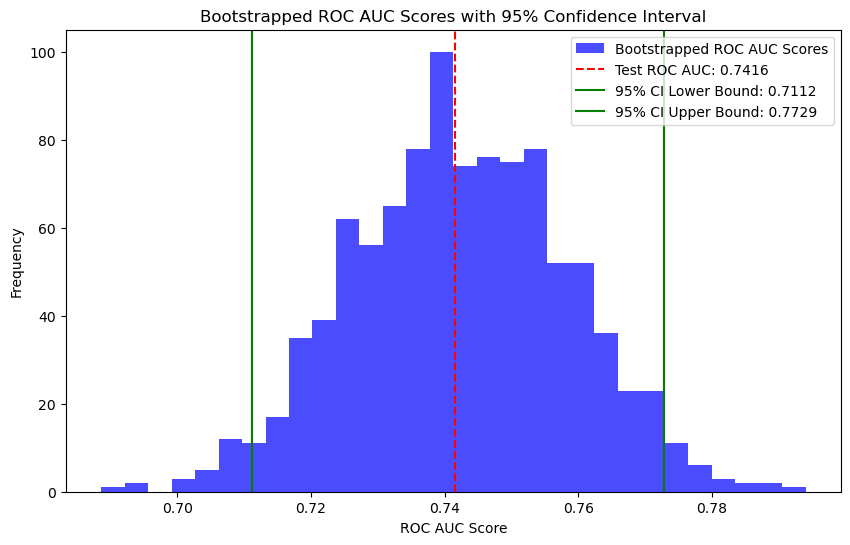

Sorted test results by predicted probabilities:
     Predicted_Probability  Actual_Profit
462               0.723056            1.0
704               0.707701            1.0
461               0.707386            1.0
714               0.707336            1.0
713               0.707336            1.0
..                     ...            ...
568               0.307104            0.0
222               0.306350            0.0
878               0.305929            0.0
226               0.302268            0.0
293               0.300781            0.0

[922 rows x 2 columns]
Top 10 predicted probabilities and actual profits:
     Predicted_Probability  Actual_Profit
462               0.723056            1.0
704               0.707701            1.0
461               0.707386            1.0
714               0.707336            1.0
713               0.707336            1.0
180               0.707140            1.0
181               0.707140            1.0
196               0.706975           

In [3]:
import matplotlib.pyplot as plt

# Function to plot the bootstrapped ROC AUC scores with the confidence interval
def plot_bootstrap_results(bootstrapped_scores, roc_auc_test, lower_bound, upper_bound):
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution of bootstrapped scores
    plt.hist(bootstrapped_scores, bins=30, alpha=0.7, color='blue', label='Bootstrapped ROC AUC Scores')
    
    # Plot the test ROC AUC score
    plt.axvline(roc_auc_test, color='red', linestyle='--', label=f'Test ROC AUC: {roc_auc_test:.4f}')
    
    # Plot the confidence interval
    plt.axvline(lower_bound, color='green', linestyle='-', label=f'95% CI Lower Bound: {lower_bound:.4f}')
    plt.axvline(upper_bound, color='green', linestyle='-', label=f'95% CI Upper Bound: {upper_bound:.4f}')
    
    plt.title('Bootstrapped ROC AUC Scores with 95% Confidence Interval')
    plt.xlabel('ROC AUC Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Modified evaluation function to include plotting
def evaluate_with_bootstrapping_and_plotting(model, test_data, features, target, n_iterations=1000):
    y_test_pred = model.predict(test_data[features])
    y_test_pred_proba = model.predict_proba(test_data[features])[:, 1]
    print("----- Test Set Evaluation -----")
    print(classification_report(test_data[target], y_test_pred))
    
    roc_auc_test = roc_auc_score(test_data[target], y_test_pred_proba)
    print(f"Test ROC AUC: {roc_auc_test}")
    
    # Bootstrapping confidence intervals
    bootstrapped_scores = []
    for i in range(n_iterations):
        boot_sample = resample(test_data)
        y_test_pred_proba_boot = model.predict_proba(boot_sample[features])[:, 1]
        roc_auc_boot = roc_auc_score(boot_sample[target], y_test_pred_proba_boot)
        bootstrapped_scores.append(roc_auc_boot)
    
    mean_score = np.mean(bootstrapped_scores)
    lower_bound = np.percentile(bootstrapped_scores, 2.5)
    upper_bound = np.percentile(bootstrapped_scores, 97.5)
    
    print(f"Bootstrap ROC AUC Mean: {mean_score}")
    print(f"95% Confidence Interval for ROC AUC: [{lower_bound}, {upper_bound}]")
    
    # Plot the bootstrapped results
    plot_bootstrap_results(bootstrapped_scores, roc_auc_test, lower_bound, upper_bound)
    
    # Sort the test results by predicted probabilities
    test_results = pd.DataFrame({
        'Predicted_Probability': y_test_pred_proba,
        'Actual_Profit': test_data[target]
    })
    sorted_test_results = test_results.sort_values(by='Predicted_Probability', ascending=False)
    print("Sorted test results by predicted probabilities:")
    print(sorted_test_results)

    # Display top 10 predicted probabilities and actual profits
    top_n = 10
    top_n_results = sorted_test_results.head(top_n)
    print(f"Top {top_n} predicted probabilities and actual profits:")
    print(top_n_results)
    
    return sorted_test_results

# Perform evaluation with bootstrapping and plotting
sorted_test_results = evaluate_with_bootstrapping_and_plotting(calibrated_rf_clf, test_data, selected_features, target)
